In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm
!pip install -q protobuf --upgrade # without it, the evaluation code fails

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create a list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [4]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [5]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [6]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [7]:
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"

encoder_layers=2
decoder_layers=2
d_model=16

In [8]:
import pandas as pd
df_deaths_us = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_deaths_US.csv')
df_confirmed_global = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_confirmed_global.csv')
df_confirmed_us = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_confirmed_US.csv')
df_recovered_global = pd.read_csv('/content/drive/MyDrive/Covid19/time_series_covid19_recovered_global.csv')

In [9]:
df_1 = df_confirmed_us.iloc[1,11:].to_frame().reset_index()
df_1.rename(columns = {'index':'time',1:'cases'}, inplace=True)
df_1['time'] = pd.to_datetime(df_1['time'], format='%m/%d/%y')
df_1['cases'] = df_1['cases'].astype(float)
df_1.set_index('time', inplace=True)


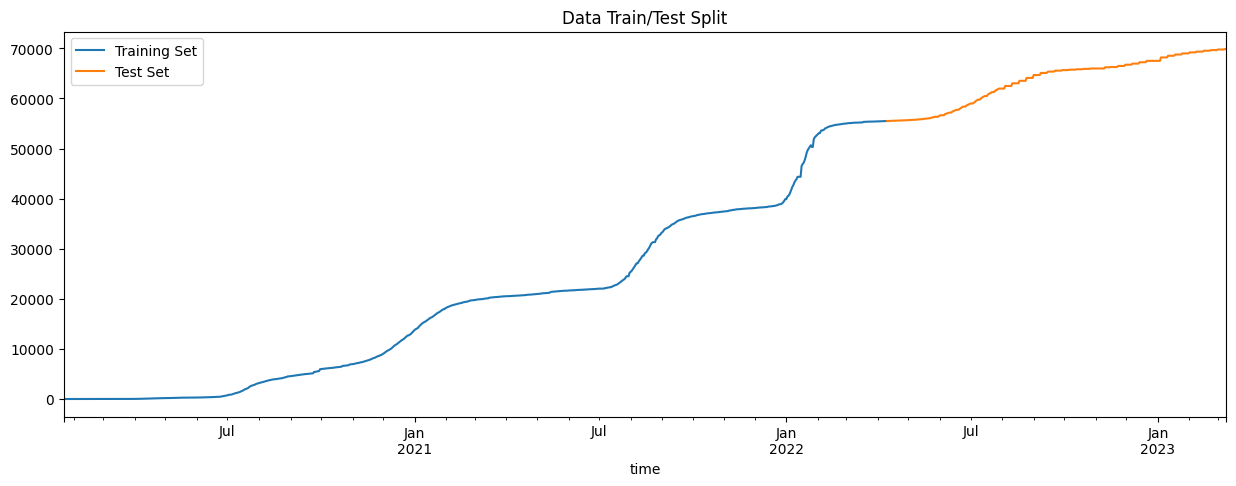

In [10]:
train = df_1.loc[df_1.index < '2022-04-10']
test = df_1.loc[df_1.index >= '2022-04-10']

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
test.shape[0]

334

In [12]:
from gluonts.torch.model.d_linear.estimator import DLinearEstimator

# Define the DLinear model with the same parameters as the Autoformer model
estimator = DLinearEstimator(
    prediction_length=test.shape[0],
    context_length=test.shape[0]*2,
    scaling=scaling,
    hidden_dimension=2,

    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    trainer_kwargs=dict(max_epochs=epochs)
)

In [13]:
predictor = estimator.train(
    training_data=train,
    cache_data=True,
    shuffle_buffer_length=1024
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type         | Params
---------------------------------------
0 | model | DLinearModel | 893 K 
---------------------------------------
893 K     Trainable params
0        

AttributeError: ignored